In [149]:
from fft_electronic_spin_density.classes import Density
import numpy as np
import matplotlib.pyplot as plt
import scipy.fft as fft

## Define a real-space function

### Define real-space function

In [ ]:
xy_lim = 3 # Angstrom
N_real_space = 201

charge_copper = 1.0
charge_ligands = 1.0
sigma_Cu = 0.1
sigma_ligands = 0.1
R_Cu_lig = 1.5
R_Cu_Cu = 1.0 # Angstrom
Cu_Ox_shift = -0.2

In [ ]:
def gaussian_orbital(x, y, x0, y0, sigma):
    """Need an extra square root in the prefactor and a /2 in the exponent so that the function squared is normalized (not the function itself), 
    since it represents a wave function, not the density."""
    n = 2
    return np.sqrt(1/(sigma**n * (2*np.pi)**(n/2))) * np.exp(-((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2) / 2)

def gaussian_orbital_copper_and_ligands(x, y, charge_copper, charge_ligands, sigma_Cu, sigma_ligands, R_Cu_lig, x_displace=1.0, x_asymmetry=-0.2):
    return charge_copper * gaussian_orbital(x, y, x_displace, 0, sigma_Cu) + \
              charge_ligands * gaussian_orbital(x, y, x_displace+x_asymmetry, R_Cu_lig, sigma_ligands) + \
                charge_ligands * gaussian_orbital(x, y, x_displace+x_asymmetry, -R_Cu_lig, sigma_ligands)

def plot_density(rho, xy_lim, title='Real-space Electronic Spin Density', cmap='berlin'):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(rho, extent=(-xy_lim, xy_lim, -xy_lim, xy_lim), origin='lower', cmap=cmap)
    ax.set_xlabel('x (Angstrom)')
    ax.set_ylabel('y (Angstrom)')
    ax.set_title(title)
    plt.colorbar(ax.imshow(rho, extent=(-xy_lim, xy_lim, -xy_lim, xy_lim), origin='lower', cmap=cmap), ax=ax)
    plt.show()

def R_phiphi(rho_overlap, dx, dy):
    """Eq. (3.4) in dimer_calculus.pdf"""
    return np.sum(rho_overlap) * dx * dy

def R_tilde_phiphi(rho_overlap, dx, dy):
    # fourier transform of overlap density
    rho_overlap_ft = fft.fftshift(fft.fftn(rho_overlap, norm='backward') )
    return rho_overlap_ft


In [152]:
# # --- check that gaussian_orbital**2 integrates to 1 ---
# N_test = 1001
# x = np.linspace(-xy_lim, xy_lim, N_test)
# y = np.linspace(-xy_lim, xy_lim, N_test)
# X, Y = np.meshgrid(x, y)

# gaussian_density = gaussian_orbital(X, Y, 0, 0, sigma_Cu) ** 2

# # integrate on a grid
# dx = 2 * xy_lim / N_test
# dy = 2 * xy_lim / N_test
# integral = np.sum(gaussian_density) * dx * dy
# print("Integral of Gaussian (should be 1.0):", integral)


In [153]:
def E_perp_simplified(xy_lim, N_real_space, x_displace=1.0, x_asymmetry=0.0):
    x = np.linspace(-xy_lim, xy_lim, N_real_space)
    y = np.linspace(-xy_lim, xy_lim, N_real_space)
    dx = 2 * xy_lim / N_real_space
    dy = 2 * xy_lim / N_real_space
    X, Y = np.meshgrid(x, y)

    phi1 = gaussian_orbital_copper_and_ligands(X, Y, charge_copper, charge_ligands, sigma_Cu, sigma_ligands, R_Cu_lig, x_displace=x_displace, x_asymmetry=x_asymmetry)
    phi2 = gaussian_orbital_copper_and_ligands(X, Y, charge_copper, charge_ligands, sigma_Cu, sigma_ligands, R_Cu_lig, x_displace=-x_displace, x_asymmetry=-x_asymmetry)

    rho_overlap_plus_R = np.conj(phi1) * phi2
    rho_overlap_minus_R = np.conj(phi2) * phi1

    rho_s = np.abs(phi1) ** 2 - np.abs(phi2) ** 2

    R_phiphi_plus_R = R_phiphi(rho_overlap_plus_R, dx, dy)
    R_phiphi_minus_R = R_phiphi(rho_overlap_minus_R, dx, dy)

    R_tilde_phiphi_plus_R = R_tilde_phiphi(rho_overlap_plus_R, dx, dy)
    R_tilde_phiphi_minus_R = R_tilde_phiphi(rho_overlap_minus_R, dx, dy)

    E_overlap = R_phiphi_plus_R * R_tilde_phiphi_minus_R - \
                R_phiphi_minus_R * R_tilde_phiphi_plus_R

    return phi1, phi2, rho_overlap_plus_R, rho_s, E_overlap, R_phiphi_plus_R, R_phiphi_minus_R, R_tilde_phiphi_plus_R, R_tilde_phiphi_minus_R

In [154]:
phi1, phi2, rho_overlap_plus_R, rho_s, E_overlap, R_phiphi_plus_R, R_phiphi_minus_R, R_tilde_phiphi_plus_R, R_tilde_phiphi_minus_R = E_perp_simplified(xy_lim=xy_lim, N_real_space=N_real_space, x_displace=R_Cu_Cu/2, x_asymmetry=Cu_Ox_shift)

In [155]:
print("R_phiphi_plus_R:", R_phiphi_plus_R)
print("R_phiphi_minus_R:", R_phiphi_minus_R)
print("max( abs(E_overlap) ):", np.max(np.abs(E_overlap)))


R_phiphi_plus_R: 0.022001158119509458
R_phiphi_minus_R: 0.022001158119509458
max( abs(E_overlap) ): 0.0


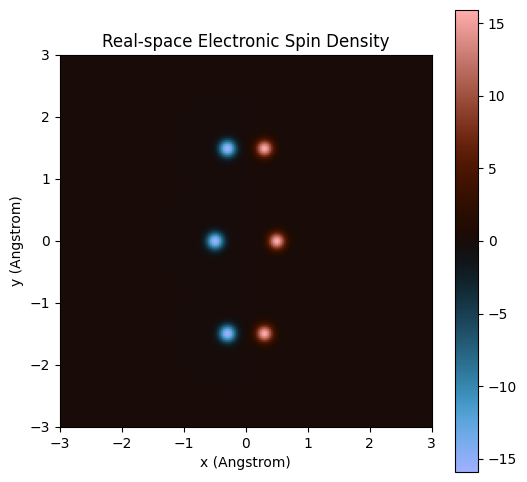

In [156]:
plot_density(rho_s, xy_lim, title='Real-space Electronic Spin Density', cmap='berlin')

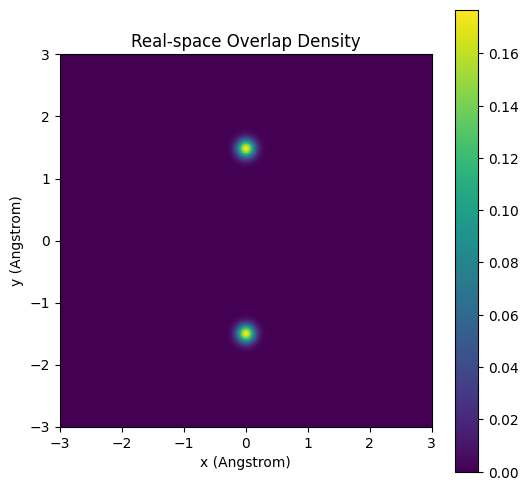

In [157]:
plot_density(rho_overlap_plus_R, xy_lim, title='Real-space Overlap Density', cmap='viridis')
